In [1]:
# Load packages
# System packages
import os
import datetime
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Data related
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', 50)

# Visualization 
import seaborn as sns, matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle

# Text analysis helper libraries
from gensim.summarization import summarize, keywords
from gensim.models import KeyedVectors

# Text analysis helper libraries for word frequency
import nltk
# Download nltk stopwords etc 
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

# Word cloud visualization libraries
from scipy.misc import imresize
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter

# Dimensionaly reduction libraries
from sklearn.decomposition import PCA

# Clustering library
from sklearn.cluster import KMeans

In [2]:
# Import custom functions
from utils_functions import *
#sys.path.append(r'Users/j/Dropbox/Learn/health_precisionmedicine/notebooks')
#sys.path

In [53]:
# Create a directory to save plots
plot_dir ='../reports/figures'
csv_dir ='../data/processed/'
createFolder(plot_dir)
createFolder(csv_dir)

## 1 EDA: 

### 1. Inspect data

In [9]:
print(os.listdir('../data/raw'))
# Input data files are available in the "../data/raw/" directory.

['training_text', 'training_variants', '.DS_Store', 'not_used', 'test_text', '.gitkeep', 'test_variants']


In [10]:
# Training Data
train_v = pd.read_csv('../data/raw/training_variants')
print('1) training_variants:')
print('')
print(train_v.head(2))

# Training text
train_t = pd.read_csv('../data/raw/training_text', sep='\|\|', header=None, skiprows=1, \
                      names=["ID","Text"],engine='python')
print('2) training_text:') 
print(train_t.head(2))
print('')

1) training_variants:

   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2) training_text:
   ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...



In [11]:
# Test Data for prediction
test_v = pd.read_csv('../data/raw/test_variants')
print('1) test_variants:') 
print(test_v.head(2))
print(' ')
# Test Text
test_t = pd.read_csv('../data/raw/test_text', sep='\|\|', header=None, skiprows=1, \
                      names=["ID","Text"],engine='python')
print('2) test_text:') 
print(test_t.head(2))
print(' ')

1) test_variants:
   ID   Gene Variation
0   0  ACSL4     R570S
1   1  NAGLU     P521L
 
2) test_text:
   ID                                               Text
0   0  2. This mutation resulted in a myeloproliferat...
1   1   Abstract The Large Tumor Suppressor 1 (LATS1)...
 


### 1.2 Prepare a new dataframe which combines all information 

In [12]:
# Merge train variants and text by unique ID
print('1)Merge train text variants and text')
print(train_v.ID.unique())
print(train_t.ID.unique())
train = pd.merge(train_v,train_t,on='ID',how='left')
print(train.head(2))
print('')


# Merge test variants and text by unique ID
print('2) Merge test text variants and text')
print(test_v.ID.unique())
print(test_t.ID.unique())
test = pd.merge(test_v,test_t,on='ID',how='left')
print(test.head(2))

1)Merge train text variants and text
[   0    1    2 ... 3318 3319 3320]
[   0    1    2 ... 3318 3319 3320]
   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   

                                                Text  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  

2) Merge test text variants and text
[   0    1    2 ... 5665 5666 5667]
[   0    1    2 ... 5665 5666 5667]
   ID   Gene Variation                                               Text
0   0  ACSL4     R570S  2. This mutation resulted in a myeloproliferat...
1   1  NAGLU     P521L   Abstract The Large Tumor Suppressor 1 (LATS1)...


In [9]:
# Save data
train.to_csv('../data/processed/train_variants_text.csv',index=False)
test.to_csv('../data/processed/test_variants_text.csv',index=False)

### 1.3 Data Munging

###  What is the prediction target?
Class
### What is the distribution of the target?

In [4]:
df = pd.read_csv('../data/processed/train_variants_text.csv')

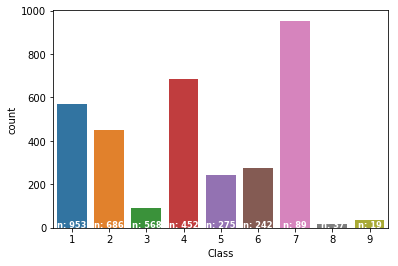

In [6]:
# Train dataset. count by Class
col_count_plot(df,'Class',plot_dir)

### What should we inspect on the data?
1) What are the column types?  
2) Are there null values in the columns?  
3) What's the unique number of column value?  
4) What are the unique values in the columns?  

In [7]:
dm(df)

,colname,dtype,Null_sum,unique_number,unique_values
3,Class,int64,0,9,"[1, 2, 3, 4, 5, 6, 7, 8, 9]"
1,Gene,object,0,264,>25
4,Text,object,5,1920,>25
2,Variation,object,0,2996,>25
0,ID,int64,0,3321,>25


### What is the distribution of the 'Gene' variable?

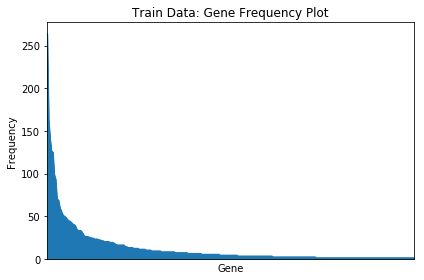

In [16]:
frequency_plot(df,'Gene',plot_dir)

### What are the most frequent genes? 

In [63]:
groupby_col_count(df, 'Gene',csv_dir)

Gene
BRCA1    264
TP53     163
EGFR     141
PTEN     126
BRCA2    125
dtype: int64

### Remove rows whose without 'Text' information

In [29]:
df= df.dropna(subset=['Text'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3316 entries, 0 to 3320
Data columns (total 5 columns):
ID           3316 non-null int64
Gene         3316 non-null object
Variation    3316 non-null object
Class        3316 non-null int64
Text         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.4+ KB


## 2. NLP analysis

### 2.1 What are the important words in the 'Text' column?

In [30]:
# TextRank algorithm from gensim
t_id = 0
text = df.loc[t_id, 'Text']

In [19]:
word_scores = keywords(text, words=5, scores=True, \
                       split=True, lemmatize=True)

word_scores
#summary = summarize(text, word_count=100)
#print('ID [{}]\nKeywords: [{}]\nSummary: [{}]'.format(t_id, word_scores, summary))


[('cdk', 0.39947685026634644),
 ('cell', 0.22782565680531897),
 ('ets', 0.21879425363167274),
 ('proteins', 0.21544496846068084),
 ('cyclins', 0.17200553147405648)]

### 2.2 Define and remove stop words and lemmatized words for word frequency analysis

In [24]:
wordnet_lemmatizer = WordNetLemmatizer()
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”"]
stop_words = set(stopwords.words('english') + list(punctuation) + custom_words)

### 2.3 Build a corpus for each class

In [28]:
class_corpus = build_corpus(df,'Class','Text',stop_words,wordnet_lemmatizer)

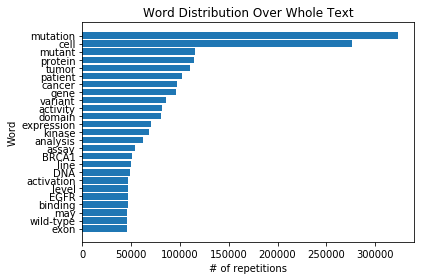

In [41]:
word_freq_plot(class_corpus, plot_dir)

### 2.4 Generate a word cloud using the corpus

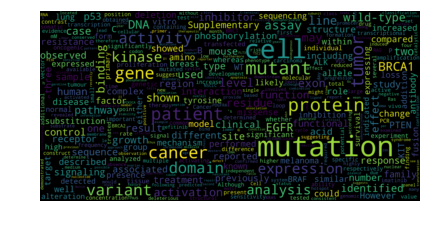

In [45]:
word_cloud_plot_no_mask(class_corpus,plot_dir)

### 2.5 Word2Vec using Google's pretrained word2vec tokens.

In [25]:
vector_path = r"/Users/j/Dropbox/Learn/kaggle_quora/src/data/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
model = KeyedVectors.load_word2vec_format (vector_path, binary=True)
model.wv.similar_by_word('mutation')



/Users/j/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


[('mutations', 0.854192316532135),
 ('genetic_mutation', 0.824504554271698),
 ('mutated_gene', 0.7879970073699951),
 ('gene_mutation', 0.7823828458786011),
 ('genetic_mutations', 0.7393666505813599),
 ('gene', 0.7343354225158691),
 ('gene_mutations', 0.7275243401527405),
 ('genetic_variant', 0.7182294130325317),
 ('alleles', 0.7164380550384521),
 ('mutant_gene', 0.7144375443458557)]

In [32]:
# Average the word vectors over a sentence
model.wv.similar_by_vector(get_average_vector(df.loc[0, 'Text'],stop_words))

/Users/j/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/Users/j/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('cyclic_AMP_cAMP', 0.7952698469161987),
 ('oncogenic_transformation', 0.7863239645957947),
 ('mRNA_transcripts', 0.7860901355743408),
 ('MT1_MMP', 0.7778975963592529),
 ('microRNA_molecule', 0.7758697271347046),
 ('tumorigenicity', 0.7754373550415039),
 ('transgene_expression', 0.7749923467636108),
 ('coexpression', 0.7743014097213745),
 ('transgenic_mice_expressing', 0.7720569968223572),
 ('cyclin_B1', 0.7714494466781616)]

### 2.5.1 PCA plot

In [41]:
# Correct the df['Text'] column to string dtype
df['Text'] = df['Text'].astype(str)

In [42]:
text_vecs = df.apply(lambda x: (x['Class'], get_average_vector(x['Text'],stop_words)), axis=1)
classes, vecs = list(zip(*text_vecs.values))

/Users/j/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


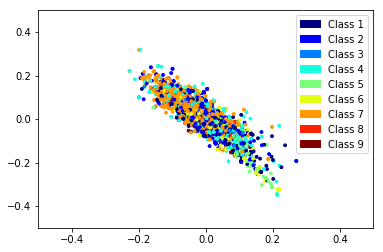

In [113]:
pca_plot(classes, vecs,plot_dir)

### 2.5.2 kmeans plot

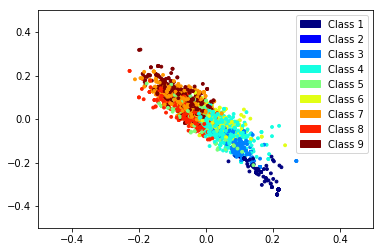

In [111]:
kmeans_plot(classes, vecs,plot_dir)